***************** CO1 COMDTY
** Minimize: Target:sharpe
optimized X:
[-0.02874293 -0.04455745  0.229843   -0.20917894  0.12618817  1.
 -0.2500441 ]
Max Leverage:
1.7892692018158471


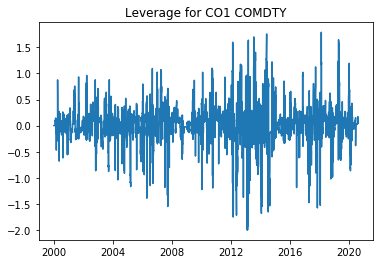

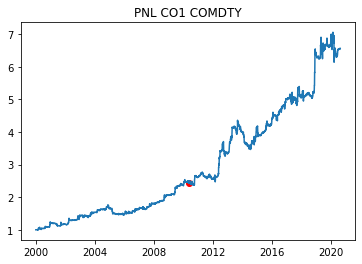

***************** SP1 INDEX
** Minimize: Target:sharpe
optimized X:
[-0.17319883  0.27001145  0.0911553   1.         -0.42054661  1.
  1.        ]
Max Leverage:
2.0


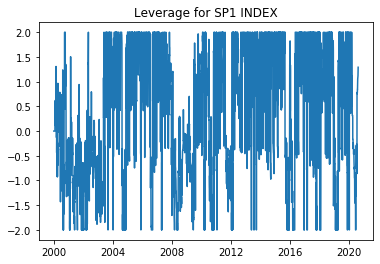

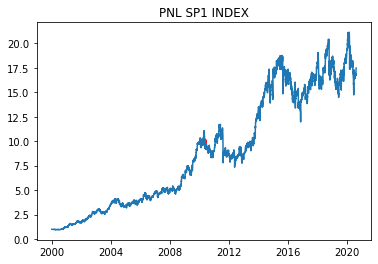

***************** TY1 COMDTY
** Minimize: Target:sharpe
optimized X:
[-0.53397737  0.11006292  0.66191305 -1.          0.68208995  0.27558581
  1.        ]
Max Leverage:
4.0


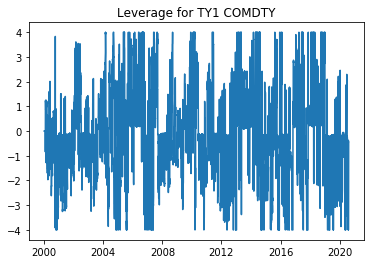

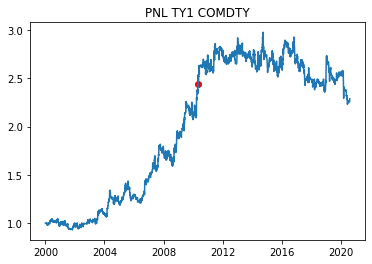

***************** HG1 COMDTY
** Minimize: Target:sharpe
optimized X:
[ 1.         -1.          1.          1.          0.25474588 -1.
  0.46363703]
Max Leverage:
2.0


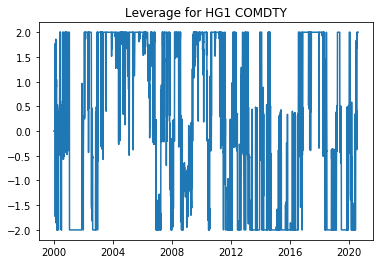

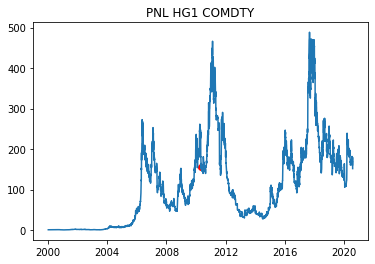

***************** NQ1 INDEX
** Minimize: Target:sharpe
optimized X:
[ 0.46852717  0.13888685  0.070263    0.27045992 -0.38925174  1.
  1.        ]
Max Leverage:
2.0


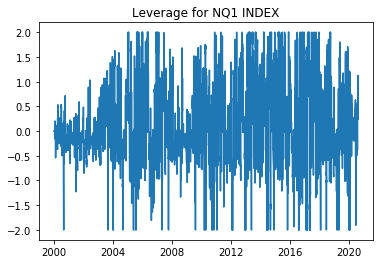

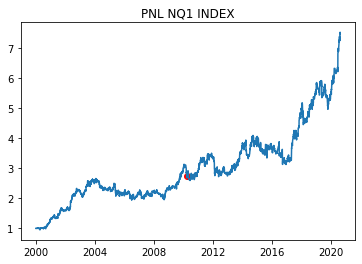

***************** GC1 COMDTY
** Minimize: Target:sharpe
optimized X:
[-1.          1.          1.          1.         -0.76766677 -1.
  1.        ]
Max Leverage:
2.0


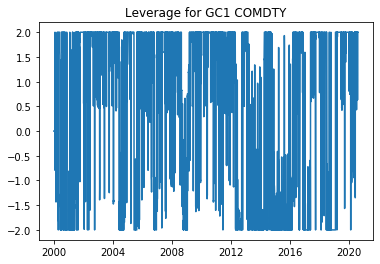

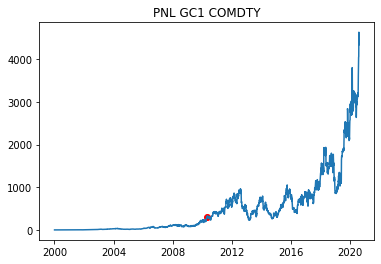

In [17]:
###OPTIMISATION OF ALGORITHMIC TRADING STRATEGIES (ATS)
## ALGO TRADING STRATEGIES ARE FIXED AND DEFINED IN PROJECT_LIB2.PY IN SIGNAL()
## EXAMPLES: MACD(50,200), RSI(14), BOLLINGER BANDS ETC
# PROGRAM WILL OPTIMISE THE WEIGHTS BETWEEN STRATEGIES PER ASSET, AND THEN OPTIMIZE THE WEIGHTS BETWEEN ASSETS
# Most functions in project_lib2.py
# Training from 2000 to 2010, testing from 2010 to today (50% in sample, 50% out of sample) 
# portfolio of Brent futures, Sp500 futures, 10-year Treasuries futures, Copper futures, Nasdaq futures, Gold futures

#imports
import pandas as pd
import project_lib2 as p ##where all the files are
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np

##########FOR PYTHON############
#answer='Y'
#assets=[]
#lot_size = []
#print("####Entering assets for the portfolio to test and trade####")

#while answer=='Y':
#    ticker = input("Enter a Bloomberg ticker to test and trade: ")
#    assets.append(ticker)
#    answer = input("Would you like to enter another ticker? (Y/N): ")
#    lotsize = int(input("Lot size? (integer): "))
#    lot_size.append(lotsize)

#start_date = input("Enter start date of training (YYYMMDD): ")
#end_date = input("Enter end date of testing (YYYMMDD): ")
#insamplefactor = float(input("Enter percentage of training data (float): "))

#AND PUT LIBRARY INSIDE SAME PYTHON FILE
################################

###INPUTS####
aum=500000000 #Money under management
assets = ['CO1 COMDTY','SP1 INDEX','TY1 COMDTY','HG1 COMDTY', 'NQ1 INDEX', 'GC1 COMDTY']
#Brent futures, Sp500 futures, 10-year Treasuries futures, Copper futures, Nasdaq futures, Gold futures
lot_size=[1000,250,1000,250,20,100] #1 point move generates that amount in USD (per asset)
start_date='20000101'
end_date='20200807'
#Insample: 50%, out of sample 50% (it can be changed in project_lib2.py in my_vars())
########

 
# %% build and backtest all

reload(p) 

def run(asset,start_date,end_date):
    #load Bloomberg data for the asset between start_date and end_date
    df = p.bbload(asset,start_date,end_date)

    # create features and signals
    df = p.feature(df,start_date,end_date)
    s  = p.signal(df)

    #backtest and optimize the x vector. All results in p.F
    p.F['optTarget'] = 'sharpe'
    
    p.backtest() # run optimization per asset and backtesting (optimize between ATS for each asset)
    p.plotresult() #plotting

    
#%% Run each asset separately and store the PNL for each. Weights are optimized between ATS for each asset   

PNL = pd.DataFrame()
POS = pd.DataFrame()
dPrices = pd.DataFrame()

for i in range( len(assets) ):
    asset = assets[i]
    print('***************** '+ asset)
    run(asset,start_date,end_date)     
    name = p.F['name'] #name of asset
    PNL[name] = p.F['pnl'].copy() # daily return per asset (p.F is a dataframe that gets written over for each asset)
    POS[name] = p.F['netlev'].copy() #daily net delta per asset (before asset portfolio optimization) 
    dPrices[name] = p.F['d']['close'].copy() #daily price per asset
#PNL
#POS

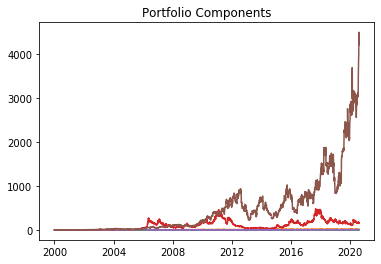

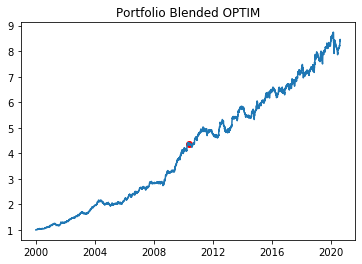

In [18]:
# %% optimize portfolio of assets (2nd optimization)
p.PF = PNL
xb = p.pfopt(PNL) #optimize between weights of assets (and plot PNL of each)

PNLw = PNL*xb  # total weighted pnl

pfcumpnl = PNLw.sum(axis=1).cumsum().apply(np.exp) #cumulative returns+1, ie the path of $1 over time

plt.plot(PNL.cumsum().apply(np.exp)) #plotting each portfolio component before weights between them
plt.title('Portfolio Components')
plt.show()

v = p.myvars() #loading global constraints variables
n = int(len(pfcumpnl) * v['insamplefactor'])  #point where out of sample starts
plt.plot(pfcumpnl) #plotting results of $1 invested at start in global portfolio
plt.title('Portfolio Blended OPTIM')
plt.scatter(pfcumpnl.index[n],pfcumpnl[n],color='r') # Red point is where Testing data starts
plt.show()
 

In [19]:
v=p.myvars()
path=PNLw.sum(axis=1)
n=len(path)
m=int(n*v['insamplefactor'])
print('Sharpe in sample: ', round(p.sharpe(path[0:m]),2))
print('Sharpe out of sample: ', round(p.sharpe(path[m+1:n]),2))
print('Volatility in sample: ', round(np.std(path[0:m])*np.sqrt(252),3))
print('Volatility out of sample: ', round(np.std(path[m+1:n])*np.sqrt(252),3))
tretIS=round(pfcumpnl[m]/pfcumpnl[0]-1,2)
print('Total return in sample: ', tretIS)
tretOS=round(pfcumpnl[n-1]/pfcumpnl[m]-1,2)
print('Total return out of sample: ', tretOS)
daysIS=m
daysOS=n-m
yearsIS=daysIS/252
yearsOS=daysOS/252
aretIS=round((1+tretIS)**(1/yearsIS)-1,4)
aretOS=round((1+tretOS)**(1/yearsOS)-1,4)
print('Annualized return in sample: ', aretIS)
print('Annualized return out of sample: ', aretOS)
print('years in sample: ', round(yearsIS,2))
print('years out of sample: ', round(yearsOS,2))

Sharpe in sample:  1.98
Sharpe out of sample:  0.81
Volatility in sample:  0.076
Volatility out of sample:  0.079
Total return in sample:  3.35
Total return out of sample:  0.93
Annualized return in sample:  0.1505
Annualized return out of sample:  0.0647
years in sample:  10.48
years out of sample:  10.48


As expected Sharpe ratio goes down between Training data (3.35 in sample) and Testing data, but it stays good (0.93 out of sample). Volatility goes up slightly from 7.6% to 7.9% between the 2 periods. Annualized returns go from 15% in sample, to 6.5% out of sample. A Sharpe of 0.81 over a 10-year period out of sample is significant.

Now we want to output trades to do at the close today, assuming we run the program a few minutes before the close.
It also outputs charts of historical trades per contract, and at the end the historical net leverage overall

Trades for CO1 : 1.0
Trades for SP1 : 4.0
Trades for TY1 : -20.0
Trades for HG1 : 0.0
Trades for NQ1 : -1.0
Trades for GC1 : 0.0


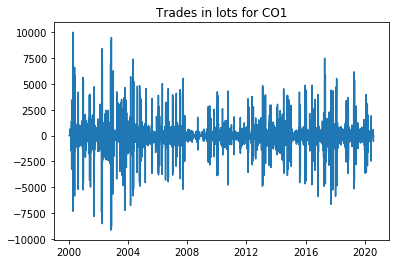

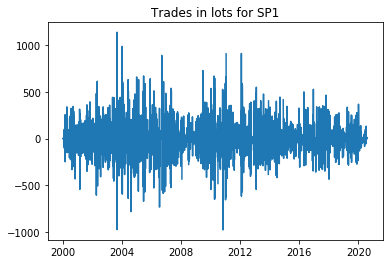

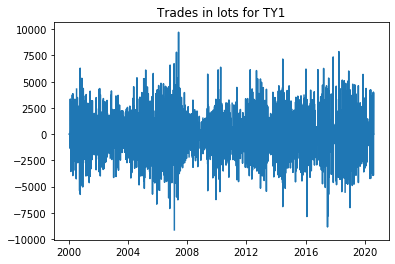

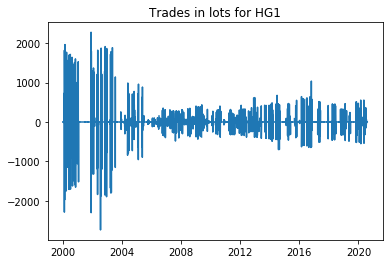

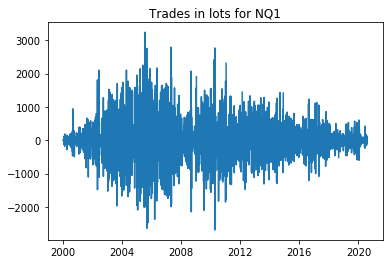

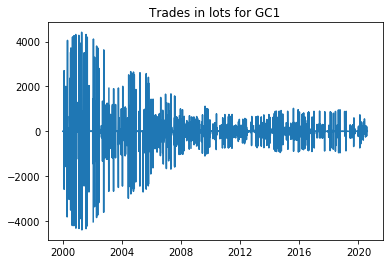

In [20]:
#Printing trades to make today. Bloomberg is loading the latest datapoint for each asset today. 
#It should be run a few minutes before the close
trades=(POS-POS.shift(1))*xb*aum #trade value in USD per day
lotvalue=dPrices*lot_size #USD value of a lot for each contract (asset)
orders=pd.DataFrame(round(trades/lotvalue)) #Dadaframe showing daily lot orders per contract

for asset in orders.columns:
    print("Trades for "+asset+" :", orders[asset].tail(1)[0]) #printing the trades to make now
    
#Showing historical trades in lots per contract for information
for asset in orders.columns:
    plt.plot(orders[asset])
    plt.title("Trades in lots for "+asset)
    plt.show()

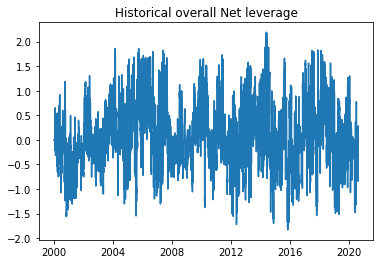

In [21]:
plt.plot((POS*xb).sum(axis=1))
plt.title("Historical overall Net leverage")
plt.show()